Integration/Test

In [1]:
from utility.data_loader import load_parquet_data
from utility.data_transformer import transform_data
import utility.wt_comparision as wt_comparision
from pathlib import Path
import optimizers.basic as basic
import optimizers.newtons_method as newtons_method
import optimizers.qp_solver as qp_solver

In [2]:
# 1. Load the data
parquet_file_path = Path().absolute().parent / 'data' / 'breuninger_user_product_event_counts_000000000000'
my_data_df = load_parquet_data(parquet_file_path, engine='pyarrow')

# 2. Transform the data
data_for_optimization = transform_data(my_data_df, lambda_1=1.0, lambda_2=0.1)    

✅ Successfully loaded data from: /Users/saloni/GIT/user-engagement-score-optimizer/data/breuninger_user_product_event_counts_000000000000
Shape: (424532, 4)
Raw data received. Shape: (424532, 4)
Transformed to wide format. 421859 User-Item pairs, 5 features: ['add_to_cart', 'add_to_wishlist', 'product_view', 'purchase', 'view_cart']



Projected Newton's Method Execution (K=5 Features)
Goal: Minimize g(w) = 1/2 w^T Q w - c^T w, subject to Simplex Constraints
--- Iteration 01 ---
  > Current Objective (Min g(w)): -314199.072110
  > Gradient Norm: 321957.772176
  > Step Change (|w_next - w|): 0.894427
  > Current Weights: add_to_cart: 0.0000, add_to_wishlist: 0.0000, product_view: 1.0000, purchase: 0.0000, view_cart: 0.0000
--- Iteration 02 ---
  > Current Objective (Min g(w)): -314199.072110
  > Gradient Norm: 321955.857242
  > Step Change (|w_next - w|): 0.000000
  > Current Weights: add_to_cart: 0.0000, add_to_wishlist: 0.0000, product_view: 1.0000, purchase: 0.0000, view_cart: 0.0000

[INFO] CONVERGENCE: Step change is below tolerance.

[INFO] Total Iterations: 2
[INFO] Time elapsed: 0.0002 seconds

[INFO] Plotting convergence history...


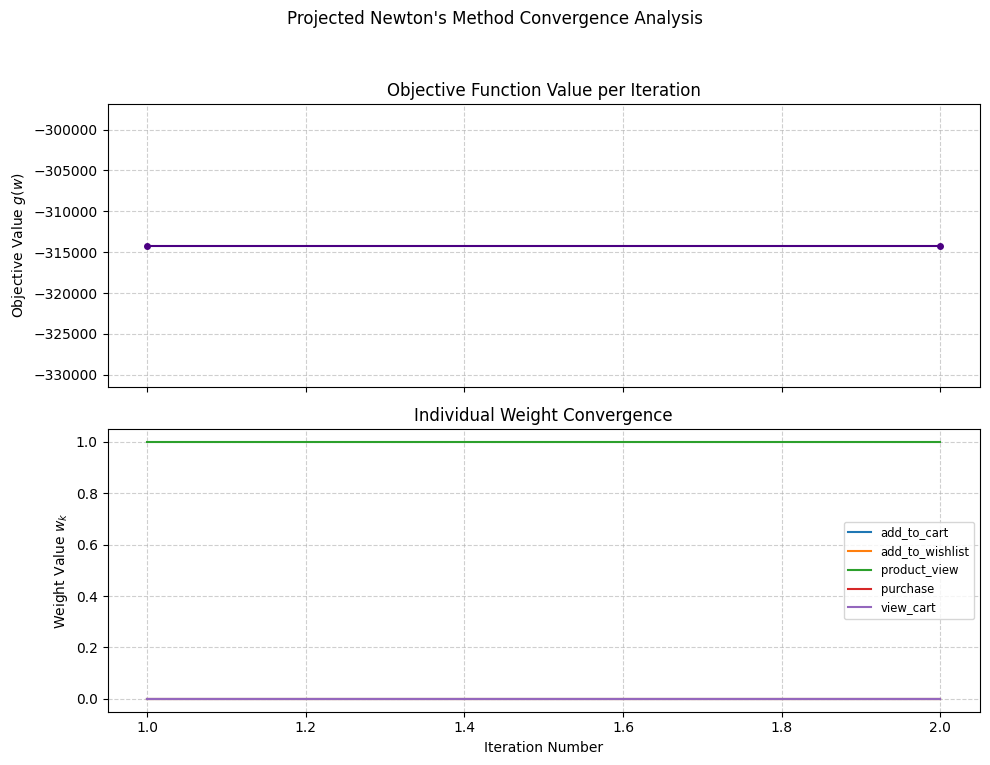

In [3]:

# 3. Solve the optimization problem using Projected Newton's Method
result_newtons_method=newtons_method.solve_with_projected_newtons_method(data_for_optimization['Q_solver'], data_for_optimization['c'], data_for_optimization['weight_names'] )
if 'history' in result_newtons_method and result_newtons_method['history']:
        print("\n[INFO] Plotting convergence history...")
        newtons_method.plot_convergence(result_newtons_method['history'], data_for_optimization['weight_names'])


In [4]:
#4.Solve with QP solver with Formal Constrained Optimization (Hierarchy)

qp_results_hirarchy_constrained = qp_solver.solve_quadratic_programming(data_for_optimization, constraints_type='hierarchy')

#4.Solve with QP solver with Simple Constrained Optimization (Penalty)
qp_results_simple_constrained = qp_solver.solve_quadratic_programming(data_for_optimization, constraints_type='simple')



Applying Logical Hierarchy Constraint:
  Constraint: w['purchase'] >= w['add_to_cart']
  Constraint: w['add_to_cart'] >= w['product_view']

--- Optimization Results ---
Solver Status: optimal
Maximized Objective Value (f(w)): 114047.1513

Optimal Weight Vector (w*):
             Event  Optimal_Weight
0      add_to_cart    3.333333e-01
1  add_to_wishlist   -1.214604e-23
2     product_view    3.333333e-01
3         purchase    3.333333e-01
4        view_cart    1.444529e-24

Applying Simple Constraints (Normalization + Non-Negativity only).

--- Optimization Results ---
Solver Status: optimal
Maximized Objective Value (f(w)): 314199.0721

Optimal Weight Vector (w*):
             Event  Optimal_Weight
0      add_to_cart    5.083119e-24
1  add_to_wishlist    5.083156e-24
2     product_view    1.000000e+00
3         purchase    5.083113e-24
4        view_cart    8.461505e-23


In [5]:
#5 hueight Calculation Method
heuristic_results = basic.calculate_heuristic_weights(data_for_optimization)

#6 log-sum Weights Calculation Method
log_sum_results = basic.calculate_log_sum_weights(data_for_optimization)





--- Generating Final Score Comparison ---


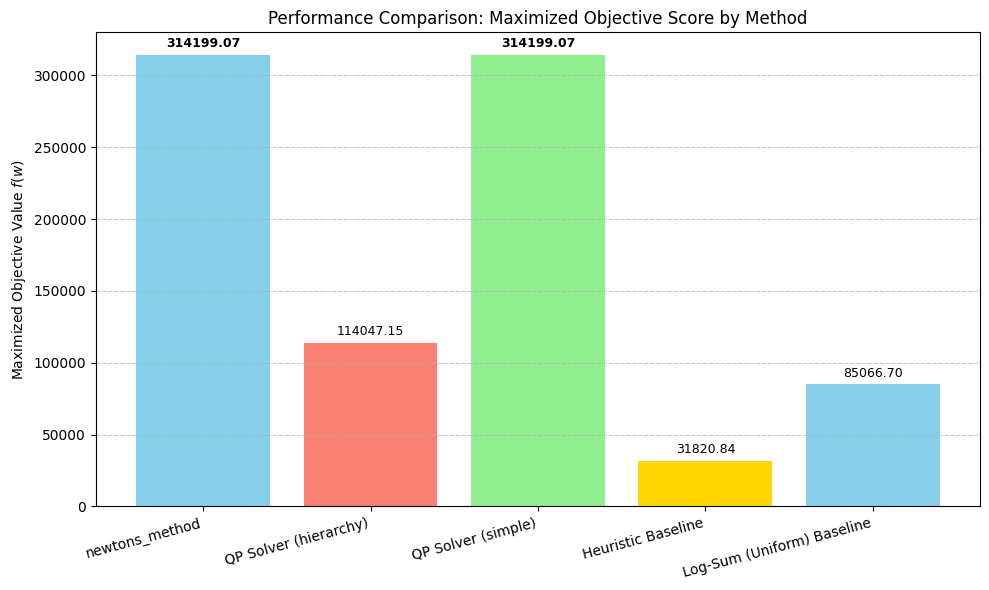

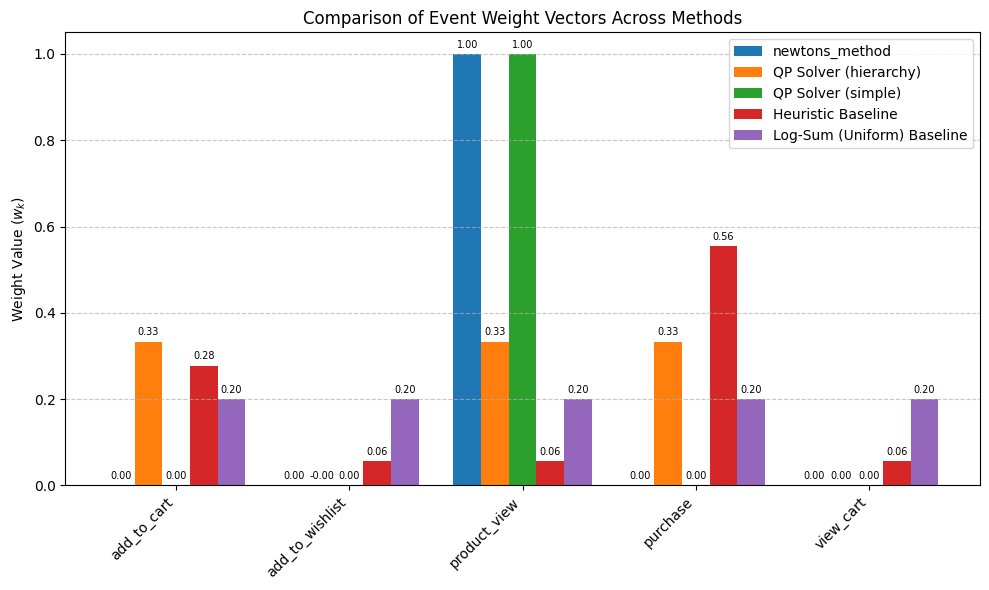


--- Best Optimization Method Found ---
Method: newtons_method
Max Objective Score (f(w)): 314199.0721

Weights for the Best Method:
                 Weight
Event                  
add_to_cart         0.0
add_to_wishlist     0.0
product_view        1.0
purchase            0.0
view_cart           0.0


In [6]:
# List to collect all weight vectors for comparison
all_weight_results = []
all_weight_results.append({**result_newtons_method, 'weight_names': data_for_optimization['weight_names']})
all_weight_results.append({**qp_results_hirarchy_constrained, 'weight_names': data_for_optimization['weight_names']})
all_weight_results.append({**qp_results_simple_constrained, 'weight_names': data_for_optimization['weight_names']})

all_weight_results.append({**heuristic_results, 'weight_names': data_for_optimization['weight_names']})
all_weight_results.append({**log_sum_results, 'weight_names': data_for_optimization['weight_names']})

# 7 Visualize the Final Scores =
print("\n\n--- Generating Final Score Comparison ---")
wt_comparision.visualize(data_for_optimization,all_weight_results)